In [2]:
import pandas as pd
import folium
import openrouteservice
from geopy.geocoders import Nominatim
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import partridge as ptg
import numpy as np

In [8]:
df2024 = pd.read_csv("Services/services-2024.csv")
df2025_1 = pd.read_csv("Services/services-2025-01.csv")
df2025_2 = pd.read_csv("Services/services-2025-02.csv")
df2025_3 = pd.read_csv("Services/services-2025-03.csv")
df2025_4 = pd.read_csv("Services/services-2025-04.csv")
df2025_5 = pd.read_csv("Services/services-2025-05.csv")
df2025_6 = pd.read_csv("Services/services-2025-06.csv")
df2025_7 = pd.read_csv("Services/services-2025-07.csv")
df2025_8 = pd.read_csv("Services/services-2025-08.csv")
df2025_9 = pd.read_csv("Services/services-2025-09.csv")
df2025_10 = pd.read_csv("Services/services-2025-10.csv")
df = pd.concat([df2024, df2025_1, df2025_2, df2025_3, df2025_4, df2025_5, df2025_6, df2025_7, df2025_8, df2025_9, df2025_10], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40417683 entries, 0 to 40417682
Data columns (total 20 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Service:RDT-ID                int64  
 1   Service:Date                  object 
 2   Service:Type                  object 
 3   Service:Company               object 
 4   Service:Train number          int64  
 5   Service:Completely cancelled  bool   
 6   Service:Partly cancelled      bool   
 7   Service:Maximum delay         int64  
 8   Stop:RDT-ID                   int64  
 9   Stop:Station code             object 
 10  Stop:Station name             object 
 11  Stop:Arrival time             object 
 12  Stop:Arrival delay            float64
 13  Stop:Arrival cancelled        object 
 14  Stop:Departure time           object 
 15  Stop:Departure delay          float64
 16  Stop:Departure cancelled      object 
 17  Stop:Platform change          bool   
 18  Stop:Planned platfor

In [ ]:
#trains_to_keep = [242, 420, 1532, 1728, 1730, 3622, 3624, 7028, 7030, 7032, 7928, 7930, 7932, 17930, 20354, 20358, 31228, 31230, 31232, 31314, 31316, 31318, 31418, 31420]
#df = df[df['Service:Train number'].isin(trains_to_keep)]
#df.info()
#df.to_csv("Services/services-peak-trains-(possible-influence-by-242).csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 131275 entries, 9 to 40369354
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Service:RDT-ID                131275 non-null  int64  
 1   Service:Date                  131275 non-null  object 
 2   Service:Type                  131275 non-null  object 
 3   Service:Company               131275 non-null  object 
 4   Service:Train number          131275 non-null  int64  
 5   Service:Completely cancelled  131275 non-null  bool   
 6   Service:Partly cancelled      131275 non-null  bool   
 7   Service:Maximum delay         131275 non-null  int64  
 8   Stop:RDT-ID                   131275 non-null  int64  
 9   Stop:Station code             131275 non-null  object 
 10  Stop:Station name             131275 non-null  object 
 11  Stop:Arrival time             116265 non-null  object 
 12  Stop:Arrival delay            116265 non-null  

In [5]:
df["Service:Company"].unique()

array(['NS Int', 'Eurobahn', 'Blauwnet', 'RRReis', 'NS'], dtype=object)

In [6]:
df = df[df["Service:Company"] == "Eu Sleeper"]
df["Service:Train number"].unique()

array([], dtype=int64)

C:\Users\niels\AppData\Local\Temp\ipykernel_15556\2504646324.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r', len(labels))


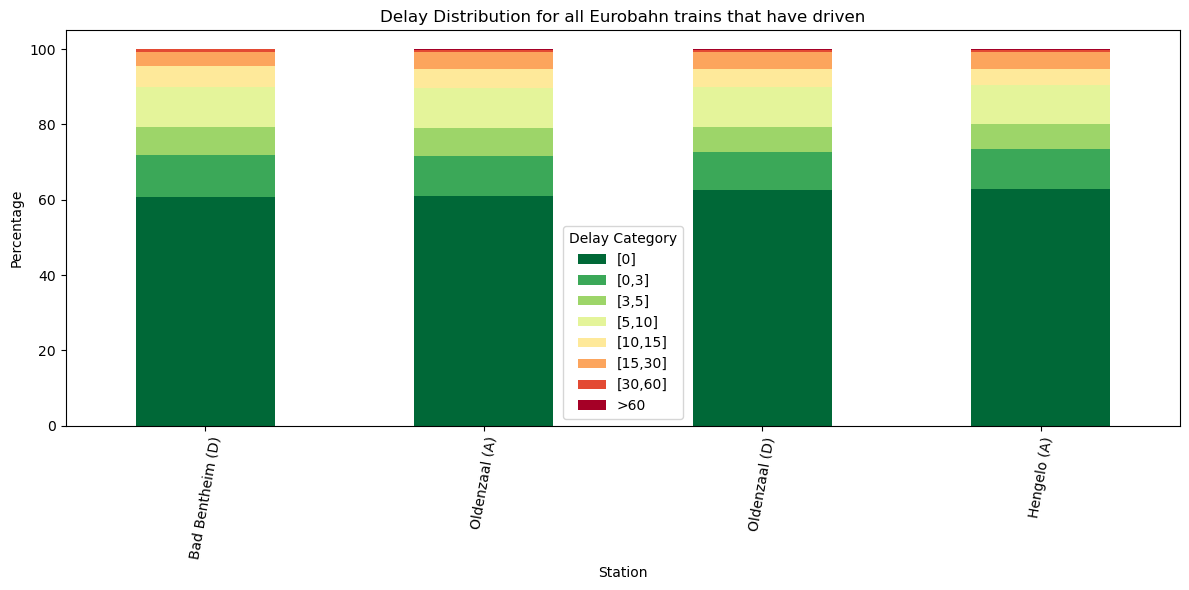

In [9]:
train_number = [20350, 20352, 20354, 20356, 20358, 20360, 20362, 20364, 20366, 20368, 20370, 20372, 20374, 20376, 20378, 20380, 20382, 20384, 20386]
df_train = df[df["Service:Train number"].isin(train_number)]
df_train = df_train[df_train["Service:Partly cancelled"] == False]
df_train.head(50)

bins = [-1, 1, 3, 5, 10, 15, 30, 60, float('inf')]
labels = ['[0]', '[0,3]', '[3,5]', '[5,10]', '[10,15]', '[15,30]', '[30,60]', '>60']

# Arrival delay
df_arrival = df_train[['Stop:Station name', 'Stop:Arrival delay', 'Stop:Arrival time']].copy()
df_arrival.rename(columns={'Stop:Arrival delay': 'Delay', 'Stop:Arrival time': 'Time'}, inplace=True)
df_arrival['Type'] = '(A)'
df_arrival['Delay category'] = pd.cut(df_arrival['Delay'], bins=bins, labels=labels)

# Departure delay
df_departure = df_train[['Stop:Station name', 'Stop:Departure delay', 'Stop:Departure time']].copy()
df_departure.rename(columns={'Stop:Departure delay': 'Delay', 'Stop:Departure time': 'Time'}, inplace=True)
df_departure['Type'] = '(D)'
df_departure['Delay category'] = pd.cut(df_departure['Delay'], bins=bins, labels=labels)

df_long = pd.concat([df_arrival, df_departure], ignore_index=True)

# Voeg kolom Station_Type toe
df_long['Station_Type'] = df_long['Stop:Station name'] + ' ' + df_long['Type']

# --- Hier kun je de volgorde zelf bepalen ---
# Bijvoorbeeld handmatig: Station1_dep, Station2_arr, Station2_dep, ...
station_order = [
    # 'Bielefeld Hbf (D)'
    # 'Berlin Ostbahnhof (D)', 
    # 'Berlin Hbf (A)', 'Berlin Hbf (D)',
    # 'Berlin-Spandau (A)', 'Berlin-Spandau (D)', 
    # 'Hannover Hbf (A)', 'Hannover Hbf (D)',
    # 'Bünde (Westf) (A)', 'Bünde (Westf) (D)', 
    # 'Osnabrück Hbf (A)', 'Osnabrück Hbf (D)', 
    # 'Rheine (A)', 'Rheine (D)',
    # 'Bad Bentheim (A)',
    'Bad Bentheim (D)', 
    'Oldenzaal (A)', 'Oldenzaal (D)',
    'Hengelo (A)', 
    # 'Hengelo (D)',
    # 'Deventer (A)', 'Deventer (D)', 'Apeldoorn (A)', 'Apeldoorn (D)',
    # 'Amersfoort Centraal (A)', 'Amersfoort Centraal (D)', 'Amsterdam Centraal (A)'
]
# Filter zodat alleen stations die in de data zitten worden meegenomen
station_order = [s for s in station_order if s in df_long['Station_Type'].unique()]

# Zet de index in de gewenste volgorde
station_delay = pd.crosstab(df_long['Station_Type'], df_long['Delay category'])
station_delay_percent = station_delay.div(station_delay.sum(axis=1), axis=0) * 100
station_delay_percent = station_delay_percent.loc[station_order]

cmap = cm.get_cmap('RdYlGn_r', len(labels))
colors = [cmap(i) for i in range(cmap.N)]

# 4. Plot gestapelde staafdiagram
station_delay_percent.plot(kind='bar', stacked=True, figsize=(12,6), color=colors)

plt.ylabel('Percentage')
plt.xlabel('Station')
plt.title(f'Delay Distribution for all Eurobahn trains that have driven')
plt.legend(title='Delay Category')
plt.xticks(rotation=80)
plt.tight_layout()
#plt.savefig(f'ICE_delay_distribution_NL.png')
plt.show()

C:\Users\niels\AppData\Local\Temp\ipykernel_15556\1150739266.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r', len(labels))


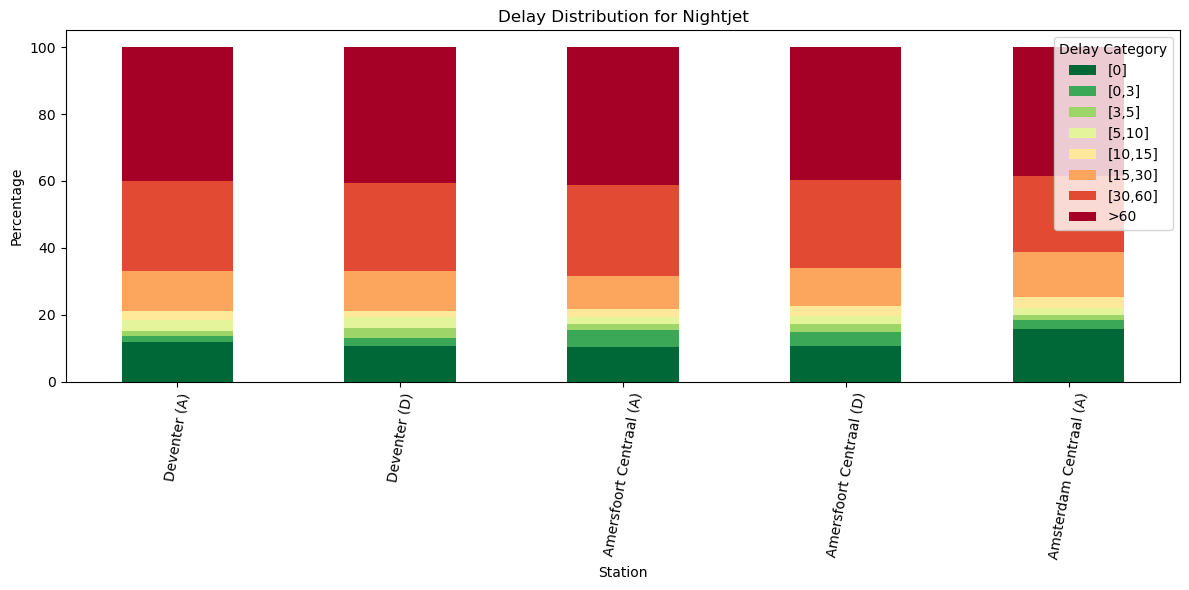

In [11]:
train_number = 420
df_train = df[df["Service:Train number"] == train_number]
df_train = df_train[df_train["Service:Partly cancelled"] == False]
df_train.head(50)

bins = [-1, 1, 3, 5, 10, 15, 30, 60, float('inf')]
labels = ['[0]', '[0,3]', '[3,5]', '[5,10]', '[10,15]', '[15,30]', '[30,60]', '>60']

# Arrival delay
df_arrival = df_train[['Stop:Station name', 'Stop:Arrival delay', 'Stop:Arrival time']].copy()
df_arrival.rename(columns={'Stop:Arrival delay': 'Delay', 'Stop:Arrival time': 'Time'}, inplace=True)
df_arrival['Type'] = '(A)'
df_arrival['Delay category'] = pd.cut(df_arrival['Delay'], bins=bins, labels=labels)

# Departure delay
df_departure = df_train[['Stop:Station name', 'Stop:Departure delay', 'Stop:Departure time']].copy()
df_departure.rename(columns={'Stop:Departure delay': 'Delay', 'Stop:Departure time': 'Time'}, inplace=True)
df_departure['Type'] = '(D)'
df_departure['Delay category'] = pd.cut(df_departure['Delay'], bins=bins, labels=labels)

df_long = pd.concat([df_arrival, df_departure], ignore_index=True)

# Voeg kolom Station_Type toe
df_long['Station_Type'] = df_long['Stop:Station name'] + ' ' + df_long['Type']

# --- Hier kun je de volgorde zelf bepalen ---
# Bijvoorbeeld handmatig: Station1_dep, Station2_arr, Station2_dep, ...
station_order = [
    #'Bad Bentheim (D)', #'Hengelo (A)', 'Hengelo (D)',
    'Deventer (A)', 'Deventer (D)', 'Apeldoorn (A)', 'Apeldoorn (D)',
    'Amersfoort Centraal (A)', 'Amersfoort Centraal (D)', 'Amsterdam Centraal (A)'
]
# Filter zodat alleen stations die in de data zitten worden meegenomen
station_order = [s for s in station_order if s in df_long['Station_Type'].unique()]

# Zet de index in de gewenste volgorde
station_delay = pd.crosstab(df_long['Station_Type'], df_long['Delay category'])
station_delay_percent = station_delay.div(station_delay.sum(axis=1), axis=0) * 100
station_delay_percent = station_delay_percent.loc[station_order]

cmap = cm.get_cmap('RdYlGn_r', len(labels))
colors = [cmap(i) for i in range(cmap.N)]

# 4. Plot gestapelde staafdiagram
station_delay_percent.plot(kind='bar', stacked=True, figsize=(12,6), color=colors)

plt.ylabel('Percentage')
plt.xlabel('Station')
plt.title(f'Delay Distribution for Nightjet')
plt.legend(title='Delay Category')
plt.xticks(rotation=80)
plt.tight_layout()
plt.savefig(f'complete_delay_distribution_nightjet_if_driven.png')
plt.show()

In [23]:
ICE_trains = [242, 240, 148, 146, 144, 142, 140]
mean_delay_list_A = []
mean_delay_list_D = []
std_delay_list_A = []
std_delay_list_D = []

for i in ICE_trains:
    df_train = df[df["Service:Train number"] == i]
    
    # Arrival
    arrival_mean = df_train['Stop:Arrival delay'].median()
    mean_delay_list_A.append(arrival_mean)
    arrival_std = df_train['Stop:Arrival delay'].std()
    std_delay_list_A.append(arrival_std)
    
    # Departure
    departure_mean = df_train['Stop:Departure delay'].median()
    mean_delay_list_D.append(departure_mean)
    departure_std = df_train['Stop:Departure delay'].std()
    std_delay_list_D.append(departure_std)
    
    print(f"Train {i}:")
    print(f"  Arrival delay: mean={arrival_mean:.2f}, std={arrival_std:.2f}")
    print(f"  Departure delay: mean={departure_mean:.2f}, std={departure_std:.2f}")
    print()

Train 242:
  Arrival delay: mean=3.00, std=13.73
  Departure delay: mean=2.00, std=12.07

Train 240:
  Arrival delay: mean=2.00, std=16.54
  Departure delay: mean=1.00, std=16.27

Train 148:
  Arrival delay: mean=3.00, std=19.79
  Departure delay: mean=2.00, std=19.33

Train 146:
  Arrival delay: mean=3.00, std=21.25
  Departure delay: mean=3.00, std=20.72

Train 144:
  Arrival delay: mean=4.00, std=17.79
  Departure delay: mean=3.00, std=17.55

Train 142:
  Arrival delay: mean=4.00, std=19.32
  Departure delay: mean=3.00, std=19.42

Train 140:
  Arrival delay: mean=6.00, std=29.76
  Departure delay: mean=5.00, std=29.36



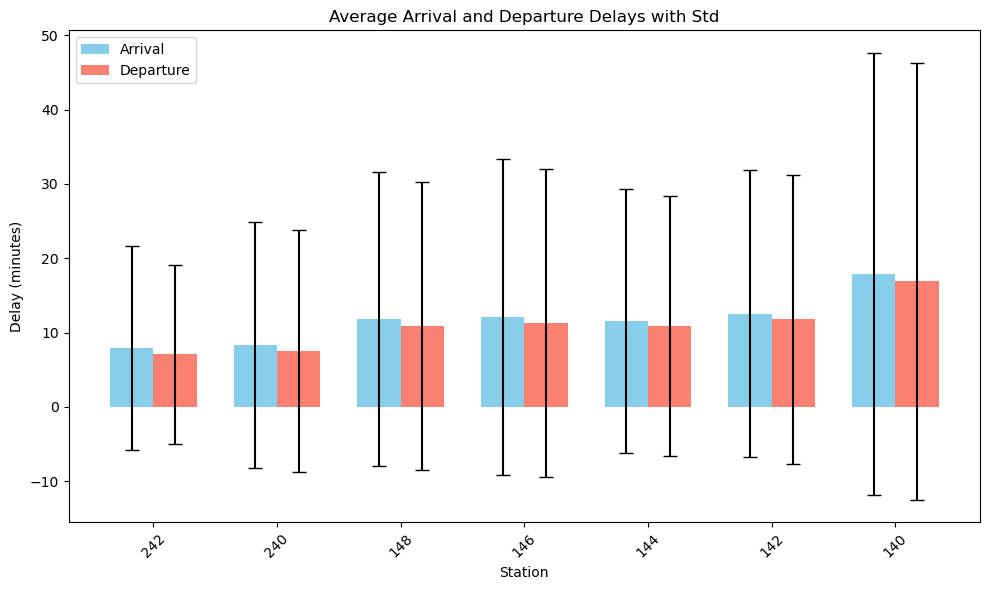

In [108]:
x = np.arange(len(ICE_trains))  # posities op de x-as
width = 0.35  # breedte van de staven

fig, ax = plt.subplots(figsize=(10,6))

# Arrival bars
ax.bar(x - width/2, mean_delay_list_A, width, yerr=std_delay_list_A, capsize=5, label='Arrival', color='skyblue')

# Departure bars
ax.bar(x + width/2, mean_delay_list_D, width, yerr=std_delay_list_D, capsize=5, label='Departure', color='salmon')

ax.set_ylabel('Delay (minutes)')
ax.set_xlabel('Station')
ax.set_title('Average Arrival and Departure Delays with Std')
ax.set_xticks(x)
ax.set_xticklabels(ICE_trains, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

C:\Users\niels\AppData\Local\Temp\ipykernel_26488\191633109.py:32: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_means = df_plot.pivot_table(index='Station_Type', columns='Service:Train number', values='Mean', aggfunc='mean')
C:\Users\niels\AppData\Local\Temp\ipykernel_26488\191633109.py:33: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_stds  = df_plot.pivot_table(index='Station_Type', columns='Service:Train number', values='Std', aggfunc='mean')


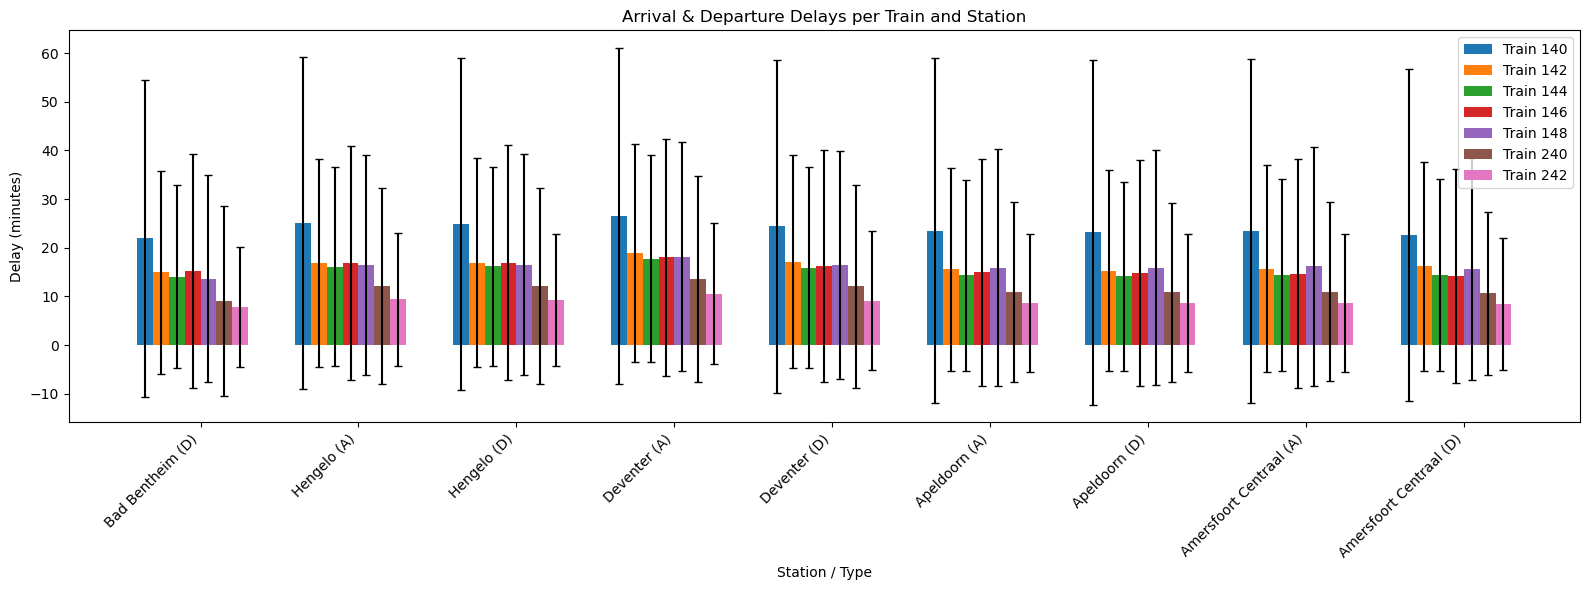

In [9]:
# --- Flatten MultiIndex columns als dat nodig is ---
if isinstance(stats.columns, pd.MultiIndex):
    stats.columns = ['_'.join(filter(None, col)).strip() for col in stats.columns.values]

# --- Maak lange DataFrame met Arrival en Departure ---
df_long = stats.reset_index()

df_arrival = df_long[['Service:Train number', 'Stop:Station name']].copy()
df_arrival['Mean'] = df_long['Stop:Arrival delay_mean']
df_arrival['Std']  = df_long['Stop:Arrival delay_std']
df_arrival['Type'] = 'A'

df_departure = df_long[['Service:Train number', 'Stop:Station name']].copy()
df_departure['Mean'] = df_long['Stop:Departure delay_mean']
df_departure['Std']  = df_long['Stop:Departure delay_std']
df_departure['Type'] = 'D'

df_plot = pd.concat([df_arrival, df_departure])
df_plot['Station_Type'] = df_plot['Stop:Station name'] + ' (' + df_plot['Type'] + ')'

# --- Handmatige volgorde van station-events ---
station_order = [
    'Bad Bentheim (D)', 'Hengelo (A)', 'Hengelo (D)',
    'Deventer (A)', 'Deventer (D)', 'Apeldoorn (A)', 'Apeldoorn (D)',
    'Amersfoort Centraal (A)', 'Amersfoort Centraal (D)'
]
station_order = [s for s in station_order if s in df_plot['Station_Type'].unique()]
df_plot['Station_Type'] = pd.Categorical(df_plot['Station_Type'], categories=station_order, ordered=True)
df_plot = df_plot.sort_values('Station_Type')

# --- Pivot voor plotten ---
df_means = df_plot.pivot_table(index='Station_Type', columns='Service:Train number', values='Mean', aggfunc='mean')
df_stds  = df_plot.pivot_table(index='Station_Type', columns='Service:Train number', values='Std', aggfunc='mean')

stations_types = df_means.index
trains = df_means.columns
x = np.arange(len(stations_types))
width = 0.1

# # --- Kleuren per Type ---
# type_colors = {'A': 'skyblue', 'D': 'salmon'}
# station_types_map = {s: 'A' if '(A)' in s else 'D' for s in stations_types}
# colors = [type_colors[station_types_map[s]] for s in stations_types]

# --- Plot ---
fig, ax = plt.subplots(figsize=(16,6))

for i, train in enumerate(trains):
    means = df_means[train].values
    stds  = df_stds[train].values
    ax.bar(x + i*width - (len(trains)/2)*width, means, width, yerr=stds, capsize=3, label=f'Train {train}')

ax.set_xticks(x)
ax.set_xticklabels(stations_types, rotation=45, ha='right')
ax.set_ylabel('Delay (minutes)')
ax.set_xlabel('Station / Type')
ax.set_title('Arrival & Departure Delays per Train and Station')
ax.legend()
plt.tight_layout()
plt.show()

In [96]:
delay_value = 58
train_analysis = [242, 240, 148, 146, 144, 142, 140, 420, 452, 454]

df_filtered = df[
    (df['Stop:Station name'] == 'Bad Bentheim') &
    (df['Stop:Departure delay'] == delay_value) &
    (df['Service:Train number'] == 242)
]

for idx, row in df_filtered.iterrows():
    print(f"Op {row['Service:Date']} had trein {row['Service:Train number']} {delay_value} minuten vertraging")
aantal = len(df_filtered)
print("Aantal gevonden rijen:", aantal)

Op 2025-05-31 had trein 242 58 minuten vertraging
Aantal gevonden rijen: 1


In [37]:
df_delay = {}

for i in range(60):
    late_rows = df[
        (df['Stop:Station name'] == 'Bad Bentheim') &
        (df['Stop:Departure delay'] == i) &
        (df['Service:Train number'] == 242)
    ]

    dagen = late_rows['Service:Date'].unique()
    subset = df[df['Service:Date'].isin(dagen)]

    df_delay[i] = subset  # opslaan

In [1]:
df_delay[42].head(25)

NameError: name 'df_delay' is not defined